<a href="https://www.kaggle.com/code/adegbaju/spotify-global-music-dataset-2009-2025-analysis?scriptVersionId=289261939" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Spotify Global Music Dataset (2009-2025) Analysis
*Complete Analysis Framework with EDA, Trend Analysis, and ML Models*

# Install Dependences

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm tensorflow

Note: you may need to restart the kernel to use updated packages.


# IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# NLP Libraries (for genre analysis)
import re
from collections import Counter
import ast

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ All libraries imported successfully!")
print(f"TensorFlow Version: {tf.__version__}")


2025-12-30 16:04:02.667300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767110643.034825      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767110643.143874      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767110644.029797      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767110644.029868      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767110644.029873      17 computation_placer.cc:177] computation placer alr

✅ All libraries imported successfully!
TensorFlow Version: 2.19.0


# DATA LOADING & PREPROCESSING

In [3]:
class SpotifyDataLoader:
    """Class for loading and preprocessing Spotify datasets"""
    
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.datasets = {}
        
    def load_data(self):
        """Load all datasets"""
        print("📂 Loading datasets...")
        
        # Load main datasets
        self.datasets['recent'] = pd.read_csv('/kaggle/input/spotify-global-music-dataset-20092025/spotify_data clean.csv')
        self.datasets['historical'] = pd.read_csv('/kaggle/input/spotify-global-music-dataset-20092025/track_data_final.csv')
        
        # Add year column based on dataset source
        self.datasets['recent']['data_source'] = '2025'
        self.datasets['historical']['data_source'] = '2009-2023'
        
        # Combine datasets
        self.combined_data = pd.concat(
            [self.datasets['recent'], self.datasets['historical']], 
            ignore_index=True
        )
        
        print(f"✅ Data loaded successfully!")
        print(f"Recent data shape: {self.datasets['recent'].shape}")
        print(f"Historical data shape: {self.datasets['historical'].shape}")
        print(f"Combined data shape: {self.combined_data.shape}")
        
        return self.combined_data

    def clean_data(self, df):
        """Clean and preprocess the dataset"""
        print("🧹 Cleaning data...")
        
        # Make a copy
        df_clean = df.copy()
        
        # Handle missing values
        df_clean['artist_genres'] = df_clean['artist_genres'].fillna('Unknown')
        df_clean['explicit'] = df_clean['explicit'].fillna(False)
        
        # Convert data types
        df_clean['explicit'] = df_clean['explicit'].astype(bool)
        
        # Extract year from release date if available
        if 'release_date' in df_clean.columns:
            df_clean['release_year'] = pd.to_datetime(
                df_clean['release_date'], errors='coerce'
            ).dt.year
        
        # Parse genres (convert string representation of list to actual list)
        def parse_genres(genre_str):
            try:
                if isinstance(genre_str, str):
                    if genre_str.startswith('['):
                        return ast.literal_eval(genre_str)
                    else:
                        return [genre_str]
                return []
            except:
                return []
        df_clean['genres_list'] = df_clean['artist_genres'].apply(parse_genres)
        
        # Create genre features
        df_clean['primary_genre'] = df_clean['genres_list'].apply(
            lambda x: x[0] if x else 'Unknown'
        )
        df_clean['num_genres'] = df_clean['genres_list'].apply(len)
        
        print("✅ Data cleaning completed!")
        return df_clean
    
    def engineer_features(self, df):
        """Create new features for analysis"""
        print("🔧 Engineering features...")
        
        # Create popularity categories
        df['popularity_category'] = pd.cut(
            df['track_popularity'],
            bins=[0, 25, 50, 75, 100],
            labels=['Low', 'Medium', 'High', 'Very High']
        )
        
        # Create artist tier based on followers
        df['artist_tier'] = pd.qcut(
            df['artist_followers'],
            q=4,
            labels=['Emerging', 'Mid-level', 'Popular', 'Superstar']
        )

        # Create decade feature if year exists
        if 'release_year' in df.columns:
            df['decade'] = (df['release_year'] // 10) * 10
        
        # Create interaction features
        df['popularity_follower_ratio'] = df['track_popularity'] / (df['artist_followers'] + 1)
        
        print("✅ Feature engineering completed!")
        return df

# Initialize and load data
loader = SpotifyDataLoader({
    'recent': 'spotify_data_clean.csv',
    'historical': 'track_data_final.csv'
})

data = loader.load_data()
data_clean = loader.clean_data(data)
data_final = loader.engineer_features(data_clean)

📂 Loading datasets...
✅ Data loaded successfully!
Recent data shape: (8582, 16)
Historical data shape: (8778, 16)
Combined data shape: (17360, 17)
🧹 Cleaning data...
✅ Data cleaning completed!
🔧 Engineering features...
✅ Feature engineering completed!


# EXPLORATORY DATA ANALYSIS

📊 BASIC STATISTICS

Numeric Columns Summary:
       track_number  track_popularity  artist_popularity  artist_followers  \
count  17360.000000      17360.000000       17356.000000      1.735600e+04   
mean       5.760887         52.293836          69.843743      2.419656e+07   
std        6.035031         23.946852          19.588595      3.808461e+07   
min        1.000000          0.000000           0.000000      0.000000e+00   
25%        1.000000         39.000000          60.000000      4.899595e+05   
50%        4.000000         58.000000          74.000000      6.141719e+06   
75%        9.000000         71.000000          84.000000      2.832735e+07   
max      102.000000        100.000000         100.000000      1.455421e+08   

       album_total_tracks  track_duration_min  track_duration_ms  \
count        17360.000000         8582.000000        8778.000000   
mean            13.784562            3.492805      210157.791866   
std             11.841777            1.057970   

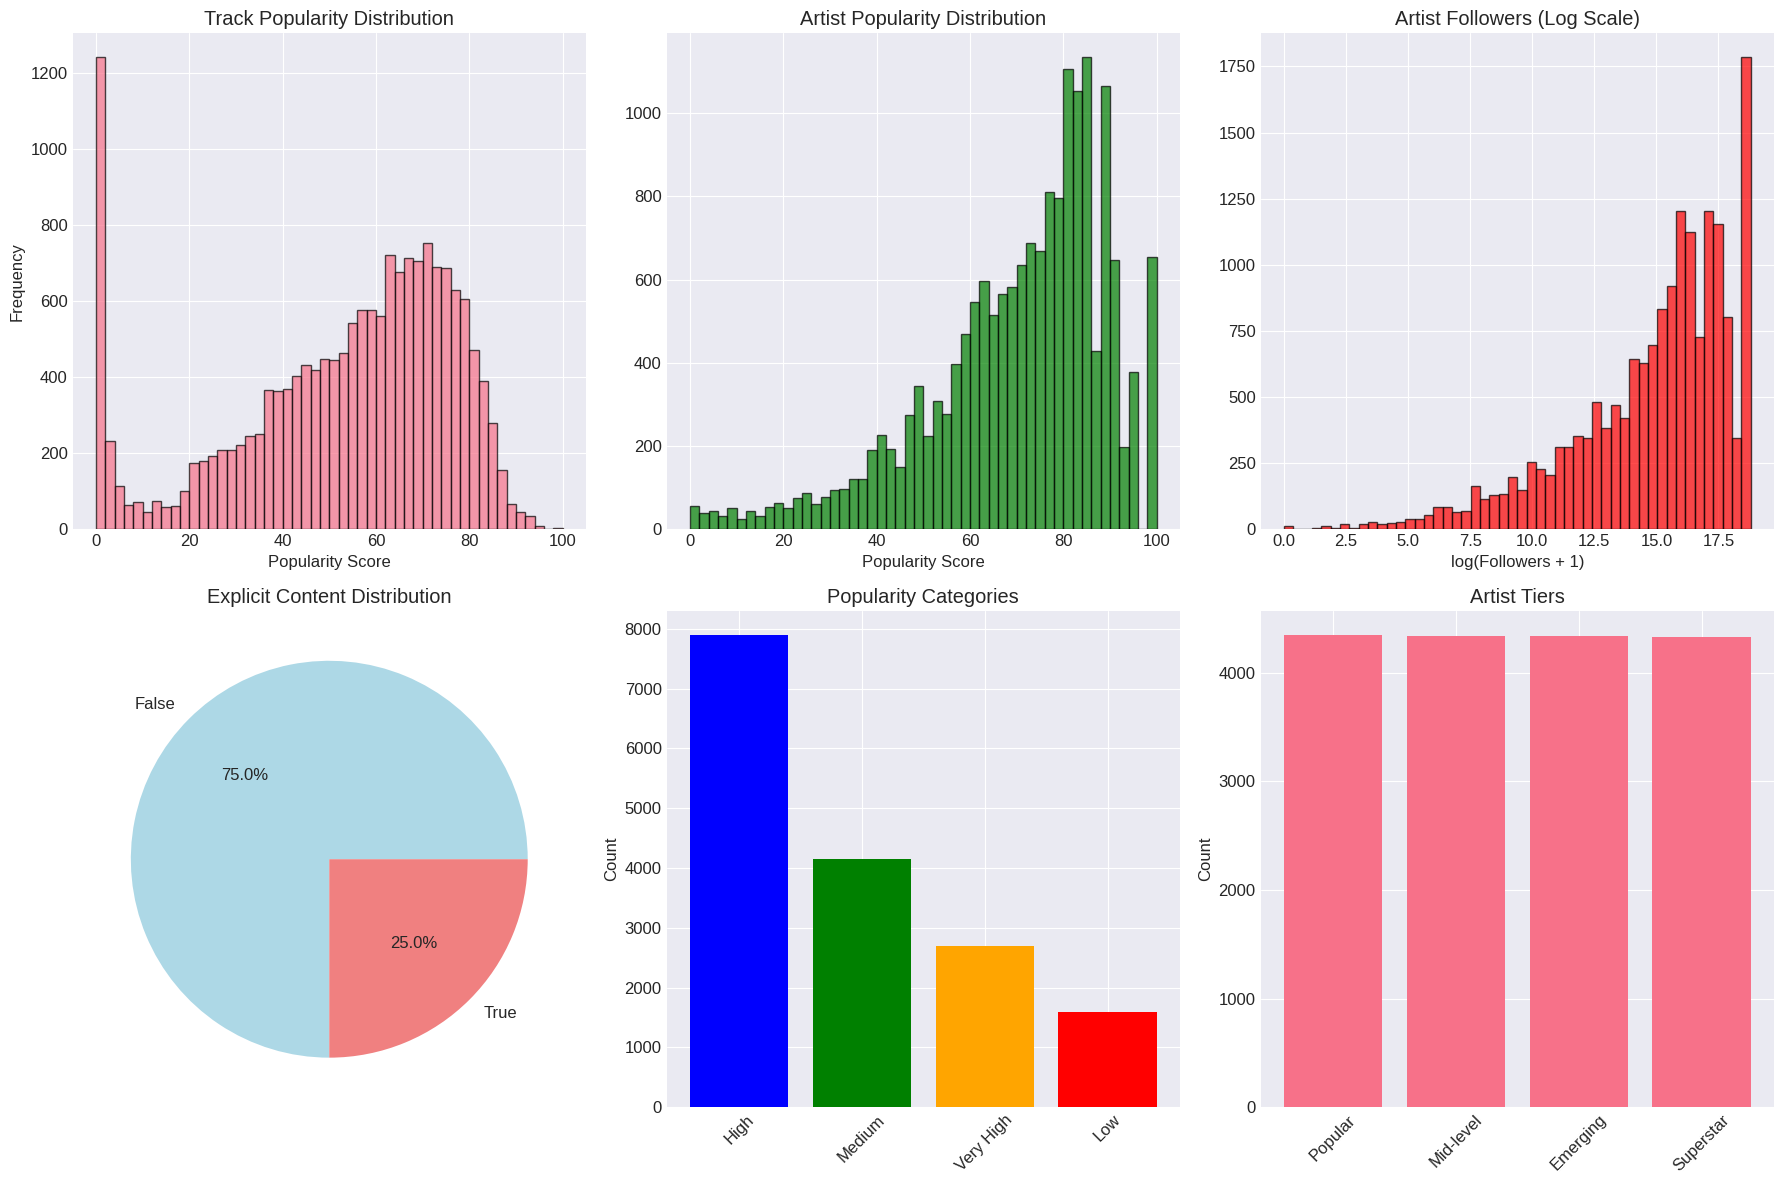

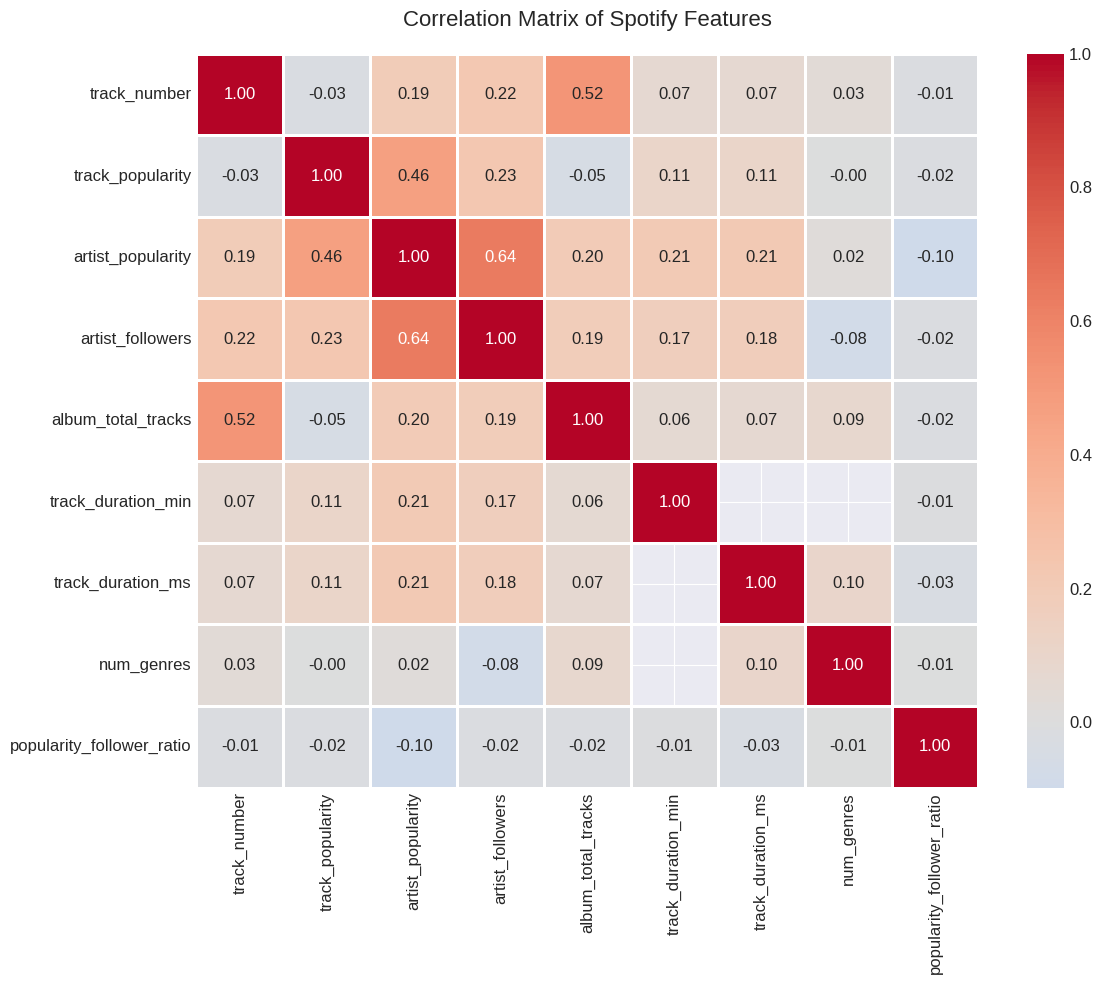


🎵 GENRE ANALYSIS


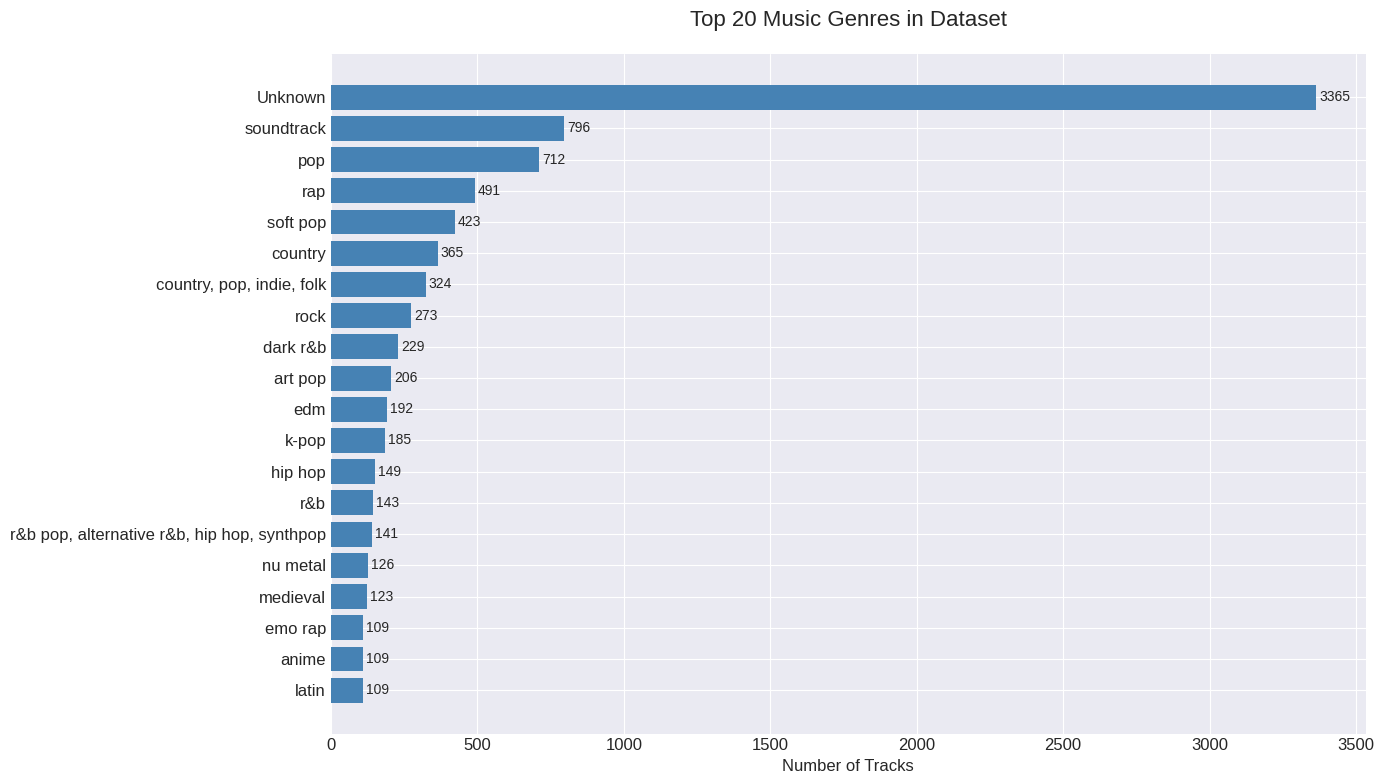


🎤 TOP 20 ARTISTS ANALYSIS


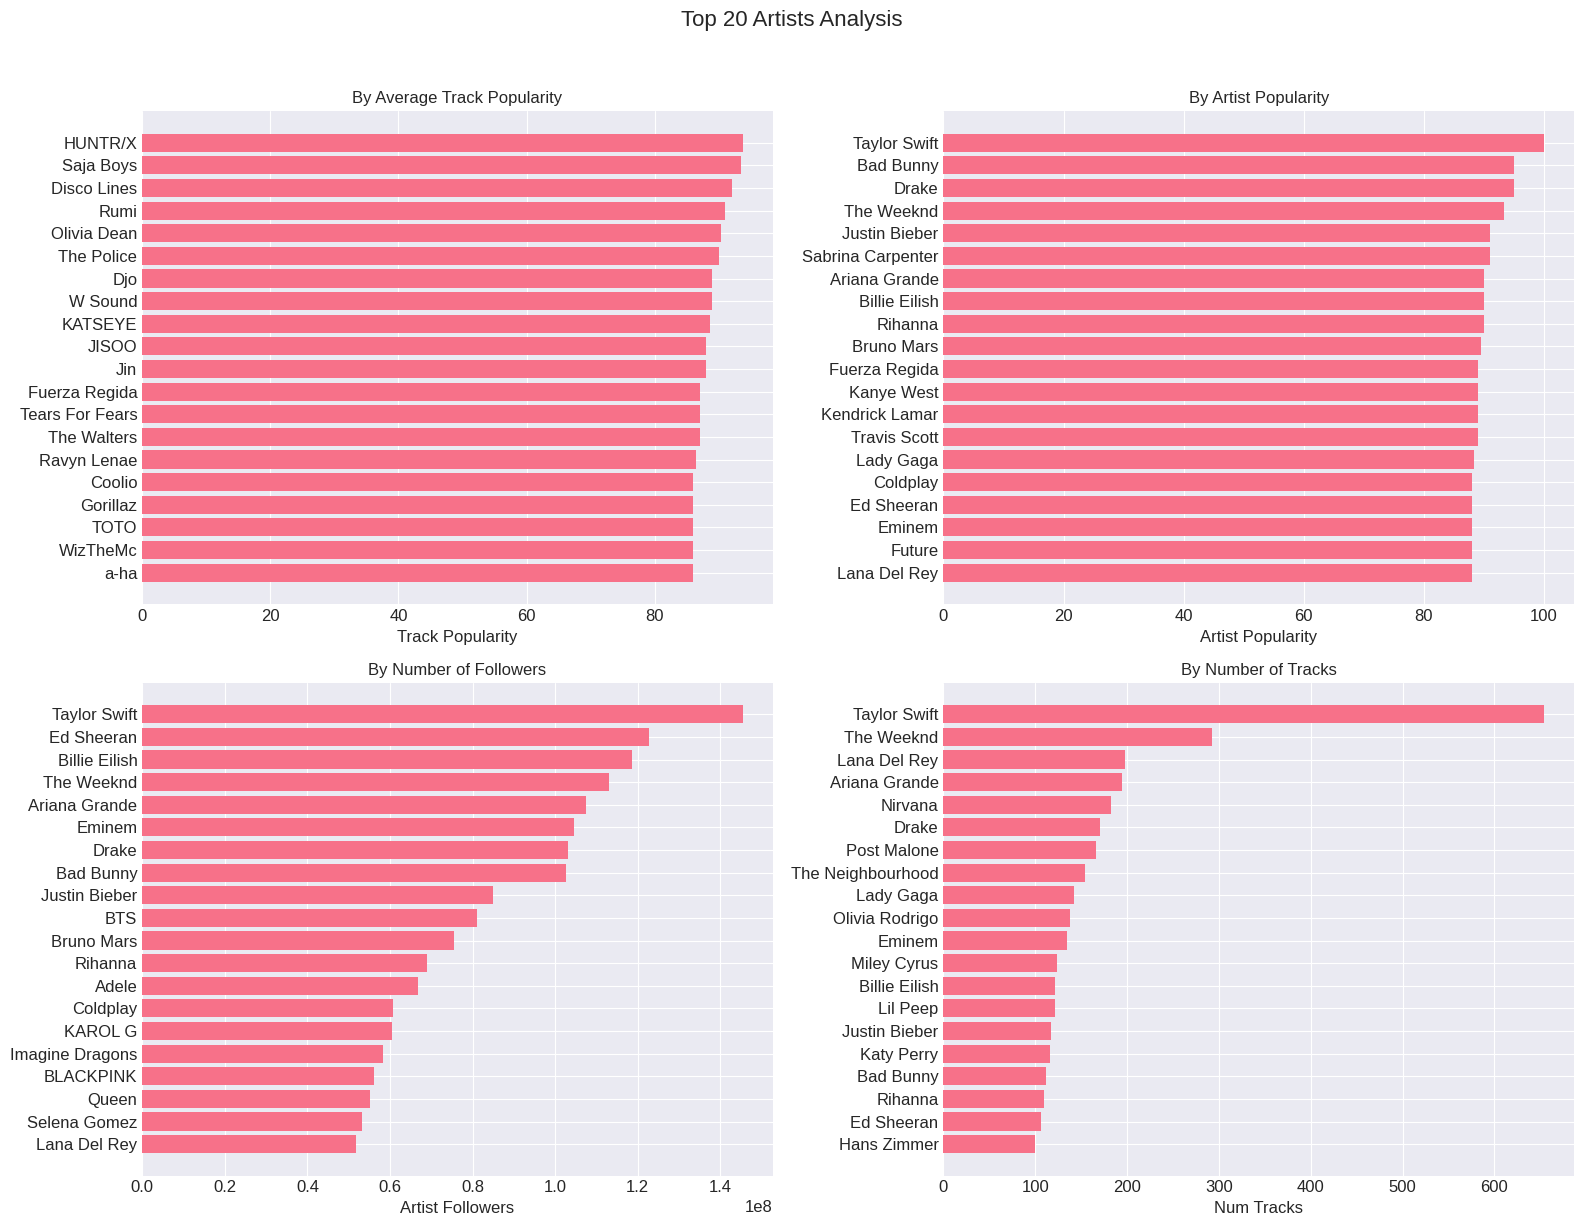

In [4]:
class SpotifyEDA:
    """Class for comprehensive EDA on Spotify data"""
    
    def __init__(self, df):
        self.df = df
        
    def basic_stats(self):
        """Display basic statistics"""
        print("📊 BASIC STATISTICS")
        print("=" * 50)
        
        # Numeric columns statistics
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        print("\nNumeric Columns Summary:")
        print(self.df[numeric_cols].describe())
        
        # Categorical columns statistics
        cat_cols = self.df.select_dtypes(include=['object', 'category']).columns
        print("\n\nCategorical Columns Summary:")
        for col in cat_cols[:5]:  # Limit to first 5 for brevity
            print(f"\n{col}:")
            print(f"Unique values: {self.df[col].nunique()}")
            print(f"Top 5 values:\n{self.df[col].value_counts().head()}")
    
    def plot_distributions(self):
        """Plot distributions of key variables"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Track Popularity Distribution
        axes[0, 0].hist(self.df['track_popularity'], bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('Track Popularity Distribution')
        axes[0, 0].set_xlabel('Popularity Score')
        axes[0, 0].set_ylabel('Frequency')
        
        # Artist Popularity Distribution
        axes[0, 1].hist(self.df['artist_popularity'], bins=50, edgecolor='black', alpha=0.7, color='green')
        axes[0, 1].set_title('Artist Popularity Distribution')
        axes[0, 1].set_xlabel('Popularity Score')
        
        # Artist Followers Distribution (log scale)
        axes[0, 2].hist(np.log1p(self.df['artist_followers']), bins=50, 
                       edgecolor='black', alpha=0.7, color='red')
        axes[0, 2].set_title('Artist Followers (Log Scale)')
        axes[0, 2].set_xlabel('log(Followers + 1)')
        
        # Explicit Content Distribution
        explicit_counts = self.df['explicit'].value_counts()
        axes[1, 0].pie(explicit_counts.values, labels=explicit_counts.index, 
                      autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
        axes[1, 0].set_title('Explicit Content Distribution')
        
        # Popularity Category Distribution
        if 'popularity_category' in self.df.columns:
            popularity_counts = self.df['popularity_category'].value_counts()
            axes[1, 1].bar(popularity_counts.index, popularity_counts.values, 
                          color=['blue', 'green', 'orange', 'red'])
            axes[1, 1].set_title('Popularity Categories')
            axes[1, 1].set_ylabel('Count')
            plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45)
        
        # Artist Tier Distribution
        if 'artist_tier' in self.df.columns:
            tier_counts = self.df['artist_tier'].value_counts()
            axes[1, 2].bar(tier_counts.index, tier_counts.values)
            axes[1, 2].set_title('Artist Tiers')
            axes[1, 2].set_ylabel('Count')
            plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_correlations(self):
        """Plot correlation matrix"""
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        
        # Select top 10 numeric columns for clarity
        if len(numeric_cols) > 10:
            numeric_cols = numeric_cols[:10]
        
        correlation_matrix = self.df[numeric_cols].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                   center=0, fmt='.2f', linewidths=1)
        plt.title('Correlation Matrix of Spotify Features', fontsize=16, pad=20)
        plt.tight_layout()
        plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def analyze_genres(self):
        """Analyze genre distributions and trends"""
        print("\n🎵 GENRE ANALYSIS")
        print("=" * 50)
        
        # Extract all genres from lists
        all_genres = []
        for genres in self.df['genres_list']:
            if isinstance(genres, list):
                all_genres.extend(genres)
        
        genre_counts = Counter(all_genres)
        
        # Top 20 genres
        top_genres = genre_counts.most_common(20)
        
        plt.figure(figsize=(14, 8))
        genres, counts = zip(*top_genres)
        
        # Create horizontal bar chart
        bars = plt.barh(range(len(genres)), counts, color='steelblue')
        plt.yticks(range(len(genres)), genres)
        plt.xlabel('Number of Tracks')
        plt.title('Top 20 Music Genres in Dataset', fontsize=16, pad=20)

         # Add value labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                    str(counts[i]), va='center', fontsize=10)
        
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('top_genres.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return top_genres
    
    def analyze_top_artists(self, top_n=20):
        """Analyze top artists by various metrics"""
        print(f"\n🎤 TOP {top_n} ARTISTS ANALYSIS")
        print("=" * 50)
        
        # Group by artist and calculate metrics
        artist_stats = self.df.groupby('artist_name').agg({
            'track_popularity': 'mean',
            'artist_followers': 'mean',
            'artist_popularity': 'mean',
            'track_id': 'count'
        }).rename(columns={'track_id': 'num_tracks'})
        
        # Sort by different metrics
        metrics = {
            'By Average Track Popularity': 'track_popularity',
            'By Artist Popularity': 'artist_popularity',
            'By Number of Followers': 'artist_followers',
            'By Number of Tracks': 'num_tracks'
        }
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, (title, metric) in enumerate(metrics.items()):
            top_artists = artist_stats.nlargest(top_n, metric)
            
            axes[idx].barh(range(top_n), top_artists[metric].values)
            axes[idx].set_yticks(range(top_n))
            axes[idx].set_yticklabels(top_artists.index)
            axes[idx].set_xlabel(metric.replace('_', ' ').title())
            axes[idx].set_title(title, fontsize=12)
            axes[idx].invert_yaxis()
        
        plt.suptitle(f'Top {top_n} Artists Analysis', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig('top_artists_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return artist_stats

# Perform EDA
eda = SpotifyEDA(data_final)
eda.basic_stats()
eda.plot_distributions()
eda.plot_correlations()
top_genres = eda.analyze_genres()
artist_stats = eda.analyze_top_artists()

# TREND ANALYSIS OVER TIME

In [5]:
class TrendAnalyzer:
    """Analyze musical trends over time"""
    
    def __init__(self, df):
        self.df = df
    
    def analyze_popularity_trends(self):
        """Analyze how popularity metrics have changed over time"""
        if 'release_year' not in self.df.columns:
            print("⚠️ No release year information available")
            return
        
        # Group by year
        yearly_stats = self.df.groupby('release_year').agg({
            'track_popularity': ['mean', 'std', 'count'],
            'artist_popularity': 'mean',
            'artist_followers': 'mean',
            'explicit': 'mean'  # Percentage of explicit tracks
        }).round(2)
        
        yearly_stats.columns = ['_'.join(col).strip() for col in yearly_stats.columns.values]
        
        # Plot trends
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Track Popularity Trend
        axes[0, 0].plot(yearly_stats.index, yearly_stats['track_popularity_mean'], 
                       marker='o', linewidth=2)
        axes[0, 0].fill_between(yearly_stats.index,
                               yearly_stats['track_popularity_mean'] - yearly_stats['track_popularity_std'],
                               yearly_stats['track_popularity_mean'] + yearly_stats['track_popularity_std'],
                               alpha=0.3)
        axes[0, 0].set_title('Average Track Popularity Over Time')
        axes[0, 0].set_xlabel('Year')
        axes[0, 0].set_ylabel('Popularity Score')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Artist Popularity Trend
        axes[0, 1].plot(yearly_stats.index, yearly_stats['artist_popularity_mean'], 
                       marker='s', color='green', linewidth=2)
        axes[0, 1].set_title('Average Artist Popularity Over Time')
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].set_ylabel('Popularity Score')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Explicit Content Trend
        axes[1, 0].bar(yearly_stats.index, yearly_stats['explicit_mean'] * 100, 
                      color='red', alpha=0.7)
        axes[1, 0].set_title('Percentage of Explicit Tracks Over Time')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_ylabel('Percentage (%)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Number of Tracks Trend
        axes[1, 1].bar(yearly_stats.index, yearly_stats['track_popularity_count'], 
                      color='purple', alpha=0.7)
        axes[1, 1].set_title('Number of Tracks Over Time')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].set_ylabel('Number of Tracks')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('Music Trends Analysis (2009-2025)', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig('trends_over_time.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return yearly_stats
    
    def analyze_genre_evolution(self, top_n_genres=10):
        """Analyze how genres have evolved over time"""
        if 'release_year' not in self.df.columns or 'genres_list' not in self.df.columns:
            print("⚠️ Required columns not available")
            return
        
        # Get top genres
        all_genres = []
        for genres in self.df['genres_list']:
            if isinstance(genres, list):
                all_genres.extend(genres)
        
        top_genres = [genre for genre, _ in Counter(all_genres).most_common(top_n_genres)]
        
        # Create genre-year matrix
        genre_year_matrix = pd.DataFrame(index=sorted(self.df['release_year'].unique()),
                                        columns=top_genres)
        
        for year in genre_year_matrix.index:
            year_data = self.df[self.df['release_year'] == year]
            year_genres = []
            
            for genres in year_data['genres_list']:
                if isinstance(genres, list):
                    # Count only top genres
                    year_genres.extend([g for g in genres if g in top_genres])
            
            genre_counts = Counter(year_genres)
            for genre in top_genres:
                genre_year_matrix.loc[year, genre] = genre_counts.get(genre, 0)
        
        # Normalize by number of tracks per year
        tracks_per_year = self.df['release_year'].value_counts().sort_index()
        for genre in top_genres:
            genre_year_matrix[genre] = genre_year_matrix[genre] / tracks_per_year * 100
        
        # Plot heatmap
        plt.figure(figsize=(14, 10))
        sns.heatmap(genre_year_matrix.T, cmap='YlOrRd', linewidths=0.5, 
                   cbar_kws={'label': 'Percentage of Tracks (%)'})
        plt.title(f'Genre Evolution Over Time (Top {top_n_genres} Genres)', 
                 fontsize=16, pad=20)
        plt.xlabel('Year')
        plt.ylabel('Genre')
        plt.tight_layout()
        plt.savefig('genre_evolution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return genre_year_matrix

# Analyze trends
trend_analyzer = TrendAnalyzer(data_final)
yearly_stats = trend_analyzer.analyze_popularity_trends()
genre_evolution = trend_analyzer.analyze_genre_evolution()



⚠️ No release year information available
⚠️ Required columns not available


# MACHINE LEARNING MODELS


🤖 PREPARING DATA FOR TRACK_POPULARITY PREDICTION
Features used: ['artist_popularity', 'artist_followers', 'num_genres', 'track_number', 'explicit', 'genre_encoded']
Training set: (13888, 6)
Test set: (3472, 6)

📈 TRAINING REGRESSION MODELS

Training Linear Regression...
  Train RMSE: 21.04, R²: 0.229
  Test RMSE: 20.66, R²: 0.254

Training Ridge Regression...
  Train RMSE: 21.04, R²: 0.229
  Test RMSE: 20.66, R²: 0.254

Training Lasso Regression...
  Train RMSE: 21.04, R²: 0.229
  Test RMSE: 20.66, R²: 0.254

Training Random Forest...
  Train RMSE: 9.48, R²: 0.843
  Test RMSE: 16.72, R²: 0.511

Training Gradient Boosting...
  Train RMSE: 19.81, R²: 0.316
  Test RMSE: 19.77, R²: 0.316

Training XGBoost...
  Train RMSE: 15.63, R²: 0.574
  Test RMSE: 18.11, R²: 0.426

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

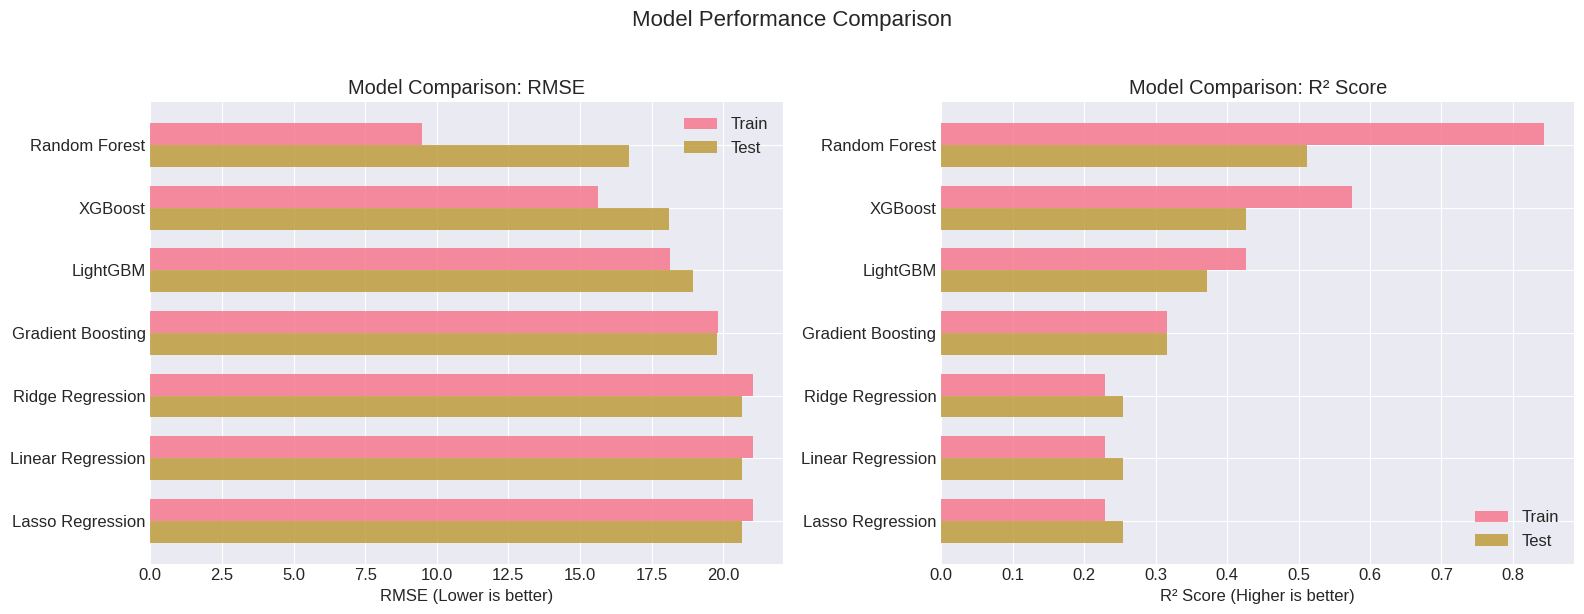


🔍 FEATURE IMPORTANCE ANALYSIS
Feature Importances:
          Feature  Importance
 artist_followers    0.348110
artist_popularity    0.334115
     track_number    0.161818
    genre_encoded    0.100555
         explicit    0.030815
       num_genres    0.024588


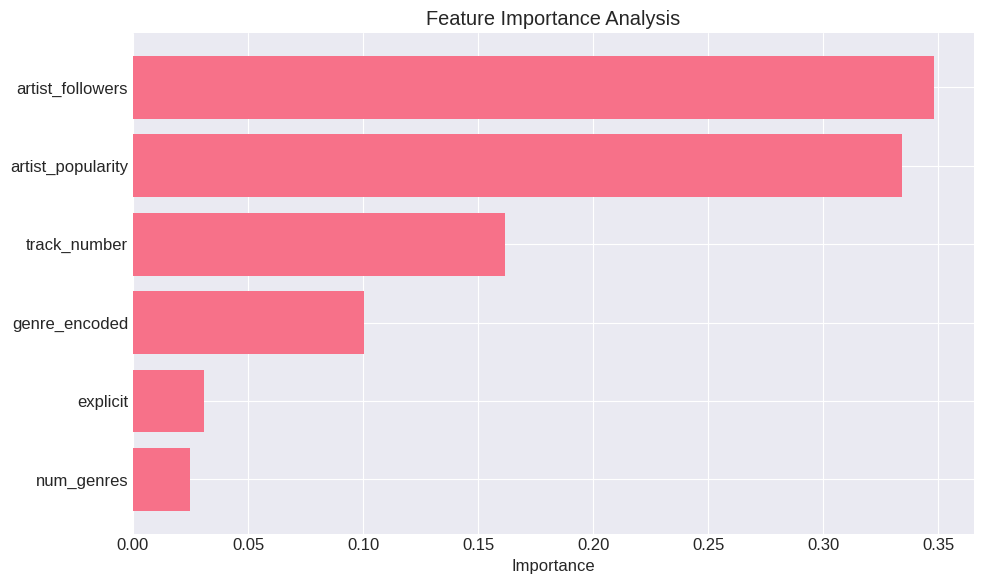

In [6]:
class SpotifyPredictiveModeling:
    """Build ML models for prediction tasks"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def prepare_popularity_prediction_data(self, target_col='track_popularity'):
        """Prepare data for popularity prediction"""
        print(f"\n🤖 PREPARING DATA FOR {target_col.upper()} PREDICTION")
        print("=" * 50)
        
        # Select features
        features = [
            'artist_popularity', 'artist_followers', 'num_genres',
            'track_number', 'explicit'
        ]
        
        # Add encoded categorical features
        if 'primary_genre' in self.df.columns:
            self.df['genre_encoded'] = self.label_encoder.fit_transform(
                self.df['primary_genre']
            )
            features.append('genre_encoded')
        
        # Ensure all features exist
        features = [f for f in features if f in self.df.columns]
        
        # Prepare X and y
        X = self.df[features].fillna(0)
        y = self.df[target_col]
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )
        
        print(f"Features used: {features}")
        print(f"Training set: {X_train.shape}")
        print(f"Test set: {X_test.shape}")
        
        return X_train, X_test, y_train, y_test, features
    
    def train_regression_models(self, X_train, X_test, y_train, y_test):
        """Train and compare multiple regression models"""
        print("\n📈 TRAINING REGRESSION MODELS")
        print("=" * 50)
        
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Lasso Regression': Lasso(alpha=0.1),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
            'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
        }
        
        results = {}
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            
            # Train model
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Calculate metrics
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            
            results[name] = {
                'model': model,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_r2': train_r2,
                'test_r2': test_r2
            }
            
            print(f"  Train RMSE: {train_rmse:.2f}, R²: {train_r2:.3f}")
            print(f"  Test RMSE: {test_rmse:.2f}, R²: {test_r2:.3f}")
        
        # Compare models
        comparison_df = pd.DataFrame([
            {
                'Model': name,
                'Train_RMSE': metrics['train_rmse'],
                'Test_RMSE': metrics['test_rmse'],
                'Train_R2': metrics['train_r2'],
                'Test_R2': metrics['test_r2']
            }
            for name, metrics in results.items()
        ]).sort_values('Test_R2', ascending=False)
        
        print("\n" + "=" * 50)
        print("MODEL COMPARISON (sorted by Test R²):")
        print("=" * 50)
        print(comparison_df.to_string(index=False))
        
        # Plot comparison
        self.plot_model_comparison(comparison_df)
        
        return results, comparison_df
    
    def plot_model_comparison(self, comparison_df):
        """Visualize model performance comparison"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # RMSE comparison
        x = range(len(comparison_df))
        width = 0.35
        axes[0].barh([i - width/2 for i in x], comparison_df['Train_RMSE'], 
                    height=width, label='Train', alpha=0.8)
        axes[0].barh([i + width/2 for i in x], comparison_df['Test_RMSE'], 
                    height=width, label='Test', alpha=0.8)
        axes[0].set_yticks(x)
        axes[0].set_yticklabels(comparison_df['Model'])
        axes[0].set_xlabel('RMSE (Lower is better)')
        axes[0].set_title('Model Comparison: RMSE')
        axes[0].legend()
        axes[0].invert_yaxis()
        
        # R² comparison
        axes[1].barh([i - width/2 for i in x], comparison_df['Train_R2'], 
                    height=width, label='Train', alpha=0.8)
        axes[1].barh([i + width/2 for i in x], comparison_df['Test_R2'], 
                    height=width, label='Test', alpha=0.8)
        axes[1].set_yticks(x)
        axes[1].set_yticklabels(comparison_df['Model'])
        axes[1].set_xlabel('R² Score (Higher is better)')
        axes[1].set_title('Model Comparison: R² Score')
        axes[1].legend()
        axes[1].invert_yaxis()
        
        plt.suptitle('Model Performance Comparison', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def feature_importance_analysis(self, best_model, feature_names):
        """Analyze feature importance for tree-based models"""
        print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
        print("=" * 50)
        
        # Check if model has feature_importances_ attribute
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
            
            # Create feature importance dataframe
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print("Feature Importances:")
            print(feature_importance_df.to_string(index=False))
            
            # Plot feature importance
            plt.figure(figsize=(10, 6))
            plt.barh(feature_importance_df['Feature'], 
                    feature_importance_df['Importance'])
            plt.xlabel('Importance')
            plt.title('Feature Importance Analysis')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            return feature_importance_df
        
        else:
            print("Feature importance not available for this model type.")
            return None

# Prepare and train ML models
ml_engine = SpotifyPredictiveModeling(data_final)
X_train, X_test, y_train, y_test, feature_names = ml_engine.prepare_popularity_prediction_data()

# Train models
results, comparison_df = ml_engine.train_regression_models(X_train, X_test, y_train, y_test)

# Analyze feature importance for the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
feature_importance_df = ml_engine.feature_importance_analysis(best_model, feature_names)

# DEEP LEARNING MODELS


🧠 TRAINING DEEP LEARNING MODELS


2025-12-30 16:04:40.580123: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training Simple NN...
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 384 (1.50 KB)

  Test MSE: 412.88
  Test MAE: 15.29
  Test R²: 0.278


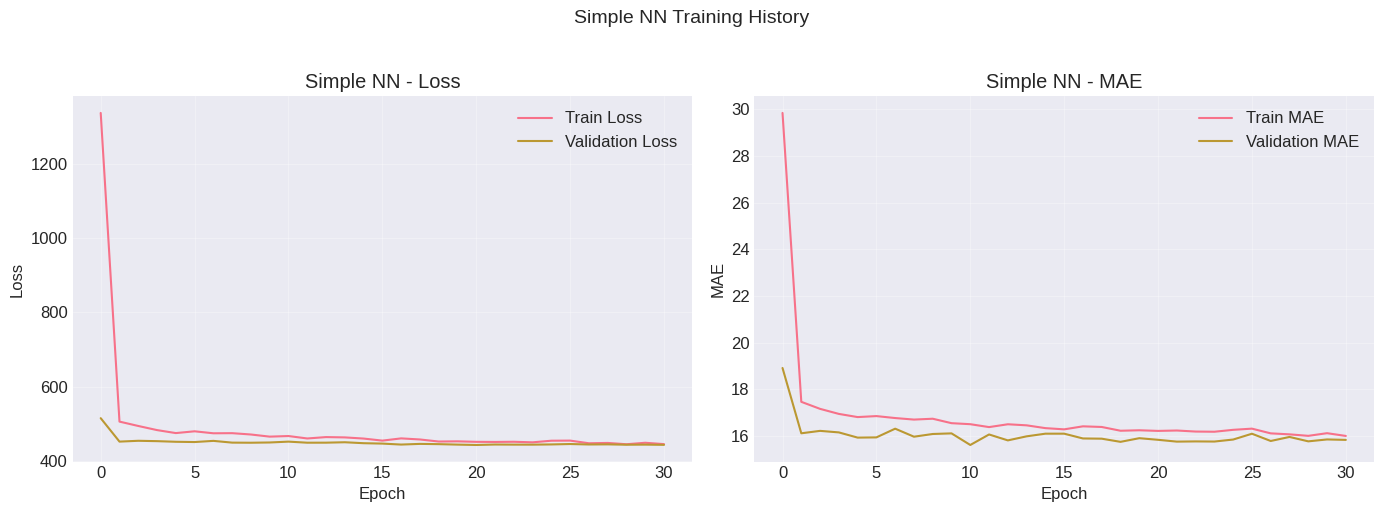


Training Deep NN...
Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 896 (3.50 KB)

  Test MSE: 414.24
  Test MAE: 15.37
  Test R²: 0.276


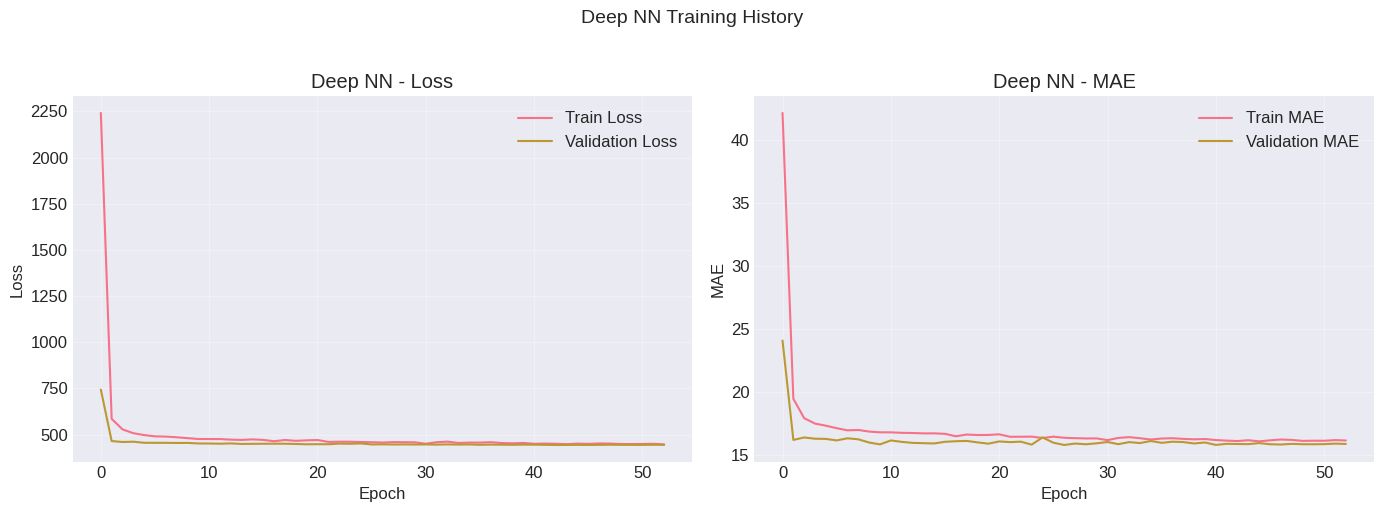

In [7]:
class DeepLearningModels:
    """Deep learning models for Spotify data"""
    
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build_simple_nn(self):
        """Build a simple neural network"""
        model = keras.Sequential([
            layers.Input(shape=self.input_shape),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)  # Output layer for regression
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )
        
        return model
    
    def build_deep_nn(self):
        """Build a deeper neural network"""
        model = keras.Sequential([
            layers.Input(shape=self.input_shape),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0005),
            loss='mse',
            metrics=['mae', 'mse']
        )
        
        return model

def train_deep_learning_models(X_train, X_test, y_train, y_test):
    """Train and evaluate deep learning models"""
    print("\n🧠 TRAINING DEEP LEARNING MODELS")
    print("=" * 50)
    
    # Build models
    dl_builder = DeepLearningModels(input_shape=(X_train.shape[1],))
    
    models = {
        'Simple NN': dl_builder.build_simple_nn(),
        'Deep NN': dl_builder.build_deep_nn()
    }
    
    history_dict = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        print(f"Model architecture:")
        model.summary()
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
        ]
        
        # Train model
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=callbacks,
            verbose=0
        )
        
        history_dict[name] = history
        
        # Evaluate model
        y_pred = model.predict(X_test, verbose=0)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"  Test MSE: {mse:.2f}")
        print(f"  Test MAE: {mae:.2f}")
        print(f"  Test R²: {r2:.3f}")
        
        # Plot training history
        plot_training_history(history, name)
    
    return models, history_dict

def plot_training_history(history, model_name):
    """Plot training history for neural networks"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title(f'{model_name} - Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot MAE
    axes[1].plot(history.history['mae'], label='Train MAE')
    axes[1].plot(history.history['val_mae'], label='Validation MAE')
    axes[1].set_title(f'{model_name} - MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)


    plt.suptitle(f'{model_name} Training History', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f'dl_{model_name.lower().replace(" ", "_")}_history.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Train deep learning models
dl_models, dl_history = train_deep_learning_models(X_train, X_test, y_train, y_test)


# CLUSTERING ANALYSIS


🎯 PERFORMING K-MEANS CLUSTERING


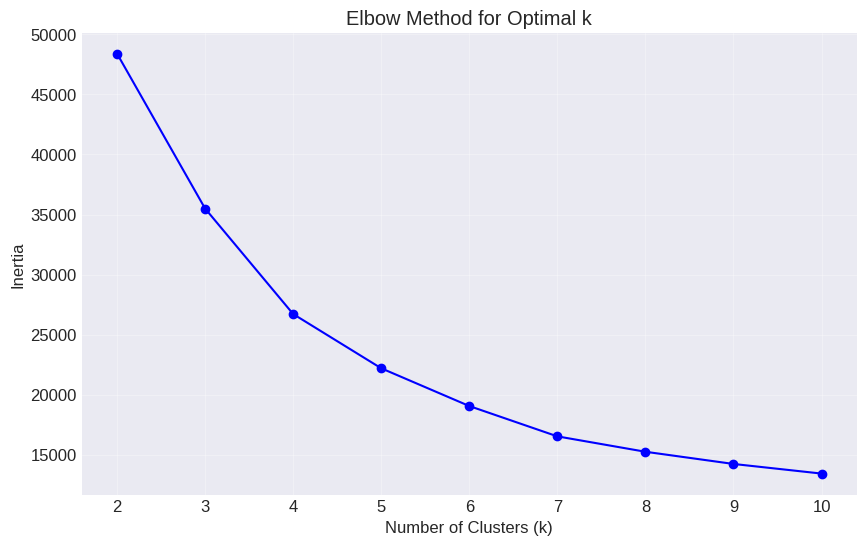

Optimal number of clusters: 4

Cluster Statistics:
              track_popularity              artist_popularity  \
                          mean    std count              mean   
cluster_label                                                   
0                        25.53  18.53  5369             50.50   
1                        62.52  18.28  2077             93.82   
2                        65.40  12.43  9142             75.65   
3                        55.70  21.70   772             71.05   

              artist_followers   artist_name  
                          mean      <lambda>  
cluster_label                                 
0                 3.554020e+06       Nirvana  
1                 1.159456e+08  Taylor Swift  
2                 1.613488e+07  Lana Del Rey  
3                 1.627481e+07     Bad Bunny  


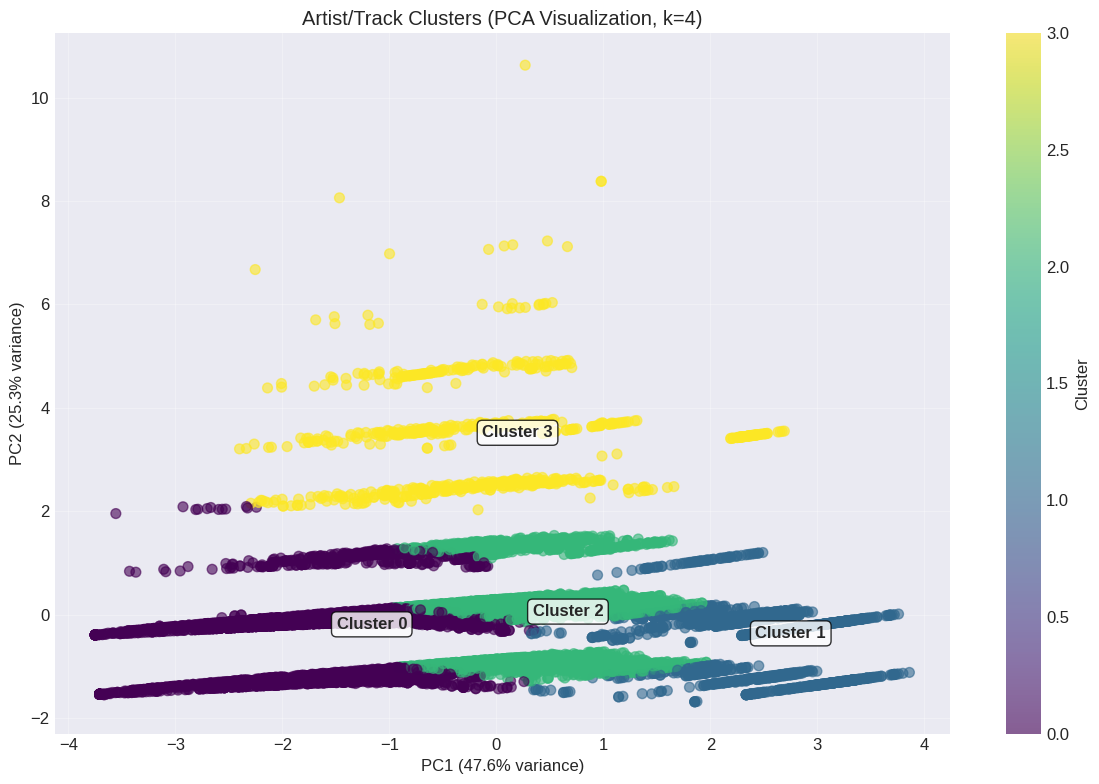

In [8]:
class SpotifyClustering:
    """Clustering analysis for artists and tracks"""
    
    def __init__(self, df):
        self.df = df
        
    def prepare_clustering_data(self):
        """Prepare data for clustering"""
        # Select features for clustering
        features = [
            'track_popularity', 'artist_popularity', 
            'artist_followers', 'num_genres'
        ]
        
        # Filter to numeric columns that exist
        features = [f for f in features if f in self.df.columns]
        
        # Prepare data
        X = self.df[features].fillna(0)
        
        # Scale data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, features
    
    def perform_kmeans_clustering(self, X_scaled, max_clusters=10):
        """Perform K-means clustering with elbow method"""
        print("\n🎯 PERFORMING K-MEANS CLUSTERING")
        print("=" * 50)
        
        # Elbow method to find optimal k
        inertias = []
        k_range = range(2, max_clusters + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertias.append(kmeans.inertia_)
        
        # Plot elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertias, 'bo-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True, alpha=0.3)
        plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Choose optimal k (you can automate this or choose manually)
        optimal_k = 4  # Based on elbow plot
        print(f"Optimal number of clusters: {optimal_k}")
        
        # Perform final clustering
        final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        clusters = final_kmeans.fit_predict(X_scaled)
        
        # Add cluster labels to dataframe
        self.df['cluster'] = clusters
        
        # Analyze clusters
        self.analyze_clusters(clusters, optimal_k)
        
        return final_kmeans, clusters
    
    def analyze_clusters(self, clusters, n_clusters):
        """Analyze and visualize cluster characteristics"""
        # Add cluster labels to dataframe
        self.df['cluster_label'] = clusters
        
        # Calculate cluster statistics
        cluster_stats = self.df.groupby('cluster_label').agg({
            'track_popularity': ['mean', 'std', 'count'],
            'artist_popularity': 'mean',
            'artist_followers': 'mean',
            'artist_name': lambda x: x.value_counts().index[0]  # Most common artist
        }).round(2)
        
        print("\nCluster Statistics:")
        print(cluster_stats)
        
        # Visualize clusters using PCA
        self.visualize_clusters_pca(n_clusters)
        
        return cluster_stats
    
    def visualize_clusters_pca(self, n_clusters):
        """Visualize clusters using PCA for dimensionality reduction"""
        # Prepare data for PCA
        features = ['track_popularity', 'artist_popularity', 'artist_followers', 'num_genres']
        features = [f for f in features if f in self.df.columns]
        
        X = self.df[features].fillna(0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Apply PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # Create dataframe for plotting
        pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        pca_df['cluster'] = self.df['cluster']
        
        # Plot clusters
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                            c=pca_df['cluster'], cmap='viridis', 
                            alpha=0.6, s=50)
        plt.colorbar(scatter, label='Cluster')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
        plt.title(f'Artist/Track Clusters (PCA Visualization, k={n_clusters})')
        plt.grid(True, alpha=0.3)
        
        # Add some sample labels for clusters
        for cluster in range(n_clusters):
            cluster_data = pca_df[pca_df['cluster'] == cluster]
            if len(cluster_data) > 0:
                # Get the centroid
                centroid = cluster_data[['PC1', 'PC2']].mean()
                plt.annotate(f'Cluster {cluster}', centroid, 
                           fontsize=12, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", 
                                   facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig('cluster_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()

# Perform clustering
clustering = SpotifyClustering(data_final)
X_scaled, features = clustering.prepare_clustering_data()
kmeans_model, clusters = clustering.perform_kmeans_clustering(X_scaled)

#  ADVANCED ANALYSIS & VISUALIZATION

Starting advanced analysis...

1. Running network analysis...

🔗 ARTIST COLLABORATION NETWORK ANALYSIS


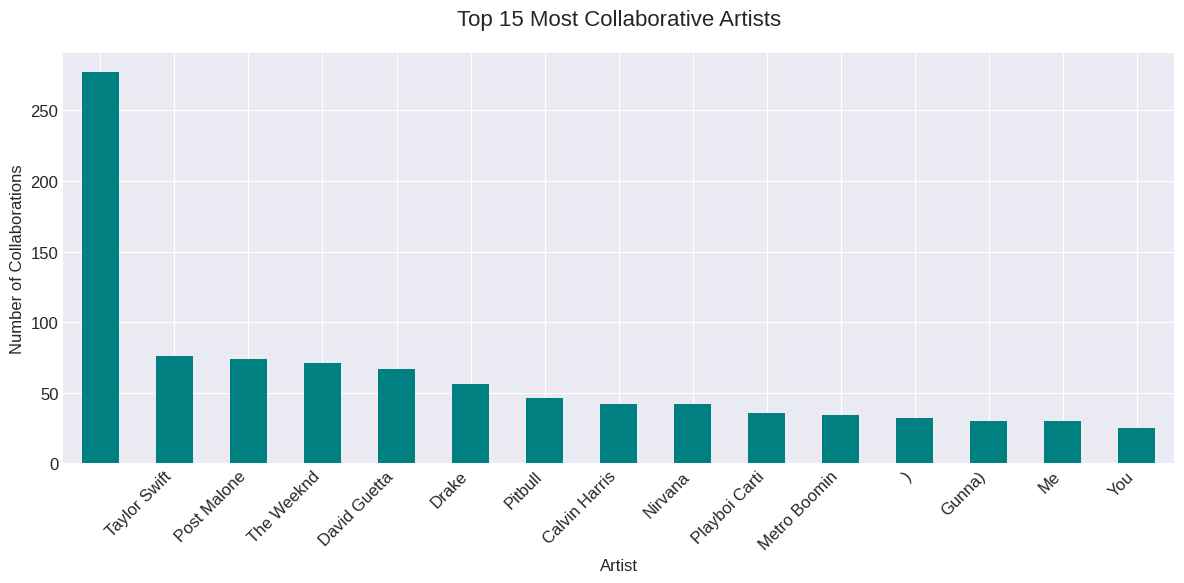


2. Running explicit content analysis...

⚠️ EXPLICIT CONTENT ANALYSIS


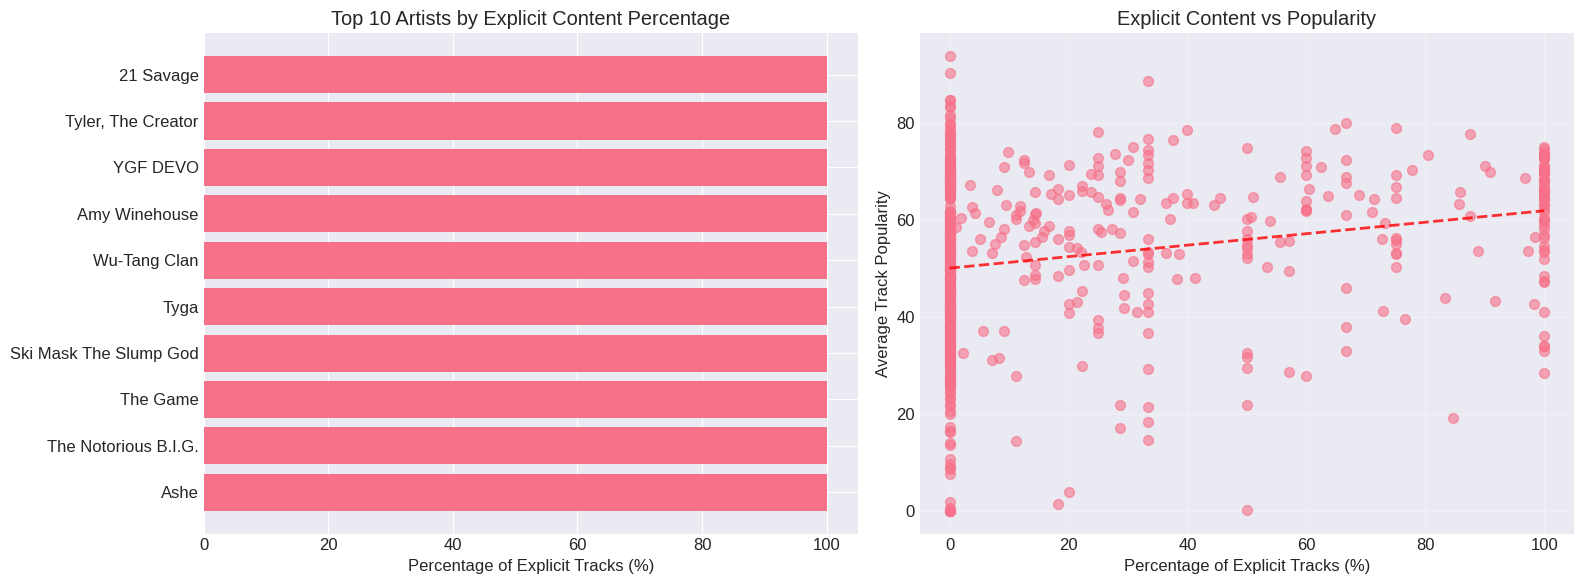

Correlation between explicit content and track popularity: 0.234

Explicit Content Statistics:
Total artists analyzed: 617
Average explicit percentage: 22.7%
Maximum explicit percentage: 100.0%

3. Running track features analysis...

🎛️ TRACK FEATURES ANALYSIS
No audio features found in the dataset

4. Running decade analysis...

📅 POPULARITY TRENDS BY DECADE
No release year information available

5. Creating dashboard data...

📊 PREPARING DATA FOR INTERACTIVE DASHBOARD
Saved dashboard_summary_stats.json
Saved dashboard_top_artists.csv
Saved dashboard_genre_distribution.csv

✅ Advanced analysis completed successfully!


In [9]:
class AdvancedAnalysis:
    """Advanced analysis techniques"""
    
    def __init__(self, df):
        self.df = df
    
    def network_analysis(self):
        """Analyze artist collaboration networks"""
        print("\n🔗 ARTIST COLLABORATION NETWORK ANALYSIS")
        print("=" * 50)
        
        # Extract collaborations from track names
        collaboration_data = []
        
        for idx, row in self.df.iterrows():
            track_name = str(row['track_name'])
            artist = str(row['artist_name'])
            
            # Look for collaboration indicators
            collaboration_indicators = ['ft.', 'feat.', 'with', '&', 'x', 'vs.']
            
            for indicator in collaboration_indicators:
                if indicator in track_name.lower():
                    # Extract featured artists
                    parts = track_name.lower().split(indicator)
                    if len(parts) > 1:
                        main_artist = artist
                        featured_artist = parts[1].strip().title()
                        
                        collaboration_data.append({
                            'main_artist': main_artist,
                            'featured_artist': featured_artist,
                            'track': track_name,
                            'popularity': row['track_popularity']
                        })
        
        if collaboration_data:
            collaborations_df = pd.DataFrame(collaboration_data)
            
            # Analyze most collaborative artists
            top_collaborators = pd.concat([
                collaborations_df['main_artist'].value_counts().head(10),
                collaborations_df['featured_artist'].value_counts().head(10)
            ]).groupby(level=0).sum().sort_values(ascending=False).head(15)
            
            plt.figure(figsize=(12, 6))
            top_collaborators.plot(kind='bar', color='teal')
            plt.title('Top 15 Most Collaborative Artists', fontsize=16, pad=20)
            plt.xlabel('Artist')
            plt.ylabel('Number of Collaborations')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig('top_collaborators.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            return collaborations_df
        
        return None
    
    def analyze_explicit_content(self):
        """Deep dive into explicit content analysis"""
        print("\n⚠️ EXPLICIT CONTENT ANALYSIS")
        print("=" * 50)
        
        if 'explicit' not in self.df.columns:
            print("Explicit column not found")
            return
        
        # Group by artist - calculate explicit percentage and total tracks
        explicit_by_artist = self.df.groupby('artist_name').agg({
            'explicit': ['mean', 'count'],
            'track_popularity': 'mean'  # Add average popularity here for consistency
        }).round(3)
        
        # Flatten column names
        explicit_by_artist.columns = ['explicit_percentage', 'total_tracks', 'avg_track_popularity']
        
        # Filter artists with enough tracks
        explicit_by_artist = explicit_by_artist[
            explicit_by_artist['total_tracks'] >= 5
        ].copy()  # Use copy to avoid SettingWithCopyWarning
        
        # Top artists by explicit content percentage
        top_explicit_artists = explicit_by_artist.sort_values(
            'explicit_percentage', ascending=False
        ).head(10)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Bar chart of top explicit artists
        axes[0].barh(top_explicit_artists.index, 
                    top_explicit_artists['explicit_percentage'] * 100)
        axes[0].set_xlabel('Percentage of Explicit Tracks (%)')
        axes[0].set_title('Top 10 Artists by Explicit Content Percentage')
        axes[0].invert_yaxis()
        
        # Scatter plot: explicit content vs popularity
        # Use the same explicit_by_artist dataframe which already contains avg_track_popularity
        axes[1].scatter(explicit_by_artist['explicit_percentage'] * 100,
                       explicit_by_artist['avg_track_popularity'],
                       alpha=0.6, s=50)
        axes[1].set_xlabel('Percentage of Explicit Tracks (%)')
        axes[1].set_ylabel('Average Track Popularity')
        axes[1].set_title('Explicit Content vs Popularity')
        axes[1].grid(True, alpha=0.3)
        
        # Add trend line
        try:
            z = np.polyfit(explicit_by_artist['explicit_percentage'] * 100, 
                          explicit_by_artist['avg_track_popularity'], 1)
            p = np.poly1d(z)
            axes[1].plot(sorted(explicit_by_artist['explicit_percentage'] * 100), 
                        p(sorted(explicit_by_artist['explicit_percentage'] * 100)),
                        "r--", alpha=0.8, linewidth=2)
        except:
            pass
        
        plt.tight_layout()
        plt.savefig('explicit_content_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Correlation between explicit content and popularity
        correlation = explicit_by_artist['explicit_percentage'].corr(
            explicit_by_artist['avg_track_popularity']
        )
        print(f"Correlation between explicit content and track popularity: {correlation:.3f}")
        
        # Additional statistics
        print(f"\nExplicit Content Statistics:")
        print(f"Total artists analyzed: {len(explicit_by_artist)}")
        print(f"Average explicit percentage: {explicit_by_artist['explicit_percentage'].mean()*100:.1f}%")
        print(f"Maximum explicit percentage: {explicit_by_artist['explicit_percentage'].max()*100:.1f}%")
        
        return explicit_by_artist
    
    def create_interactive_dashboard_data(self):
        """Prepare data for interactive dashboard"""
        print("\n📊 PREPARING DATA FOR INTERACTIVE DASHBOARD")
        print("=" * 50)
        
        # Calculate summary statistics
        summary_stats = {
            'total_tracks': len(self.df),
            'total_artists': self.df['artist_name'].nunique(),
            'avg_track_popularity': self.df['track_popularity'].mean(),
            'avg_artist_popularity': self.df['artist_popularity'].mean(),
            'explicit_percentage': (self.df['explicit'].mean() * 100 if 'explicit' in self.df.columns else 0)
        }
        
        # Create top artists dataframe
        if 'artist_followers' in self.df.columns:
            top_artists = self.df.groupby('artist_name').agg({
                'track_popularity': 'mean',
                'artist_followers': 'mean',
                'track_id': 'count'
            }).rename(columns={'track_id': 'num_tracks'}).nlargest(20, 'track_popularity')
        else:
            top_artists = self.df.groupby('artist_name').agg({
                'track_popularity': 'mean',
                'track_id': 'count'
            }).rename(columns={'track_id': 'num_tracks'}).nlargest(20, 'track_popularity')
        
        # Create genre distribution
        if 'primary_genre' in self.df.columns:
            genre_distribution = pd.Series(
                self.df['primary_genre'].value_counts().head(15)
            )
        else:
            genre_distribution = pd.Series()
        
        # Create yearly trends if release_year exists
        if 'release_year' in self.df.columns:
            yearly_trends = self.df.groupby('release_year').agg({
                'track_popularity': 'mean',
                'artist_popularity': 'mean',
                'track_id': 'count'
            }).rename(columns={'track_id': 'num_tracks'})
        else:
            yearly_trends = None
        
        dashboard_data = {
            'summary_stats': summary_stats,
            'top_artists': top_artists,
            'genre_distribution': genre_distribution,
            'yearly_trends': yearly_trends
        }
        
        # Save to files for dashboard
        for key, data in dashboard_data.items():
            if key == 'summary_stats':
                # Save summary stats as JSON
                import json
                with open('dashboard_summary_stats.json', 'w') as f:
                    json.dump(data, f, indent=2)
                print(f"Saved dashboard_summary_stats.json")
            elif isinstance(data, pd.DataFrame) and not data.empty:
                filename = f'dashboard_{key}.csv'
                data.to_csv(filename)
                print(f"Saved {filename}")
            elif isinstance(data, pd.Series) and not data.empty:
                filename = f'dashboard_{key}.csv'
                data.to_csv(filename, header=['count'])
                print(f"Saved {filename}")
            elif data is not None and not isinstance(data, dict):
                filename = f'dashboard_{key}.csv'
                try:
                    data.to_csv(filename)
                    print(f"Saved {filename}")
                except:
                    print(f"Could not save {key}")
        
        return dashboard_data
    
    def analyze_track_features(self):
        """Analyze track features if available in the dataset"""
        print("\n🎛️ TRACK FEATURES ANALYSIS")
        print("=" * 50)
        
        # Check for common Spotify audio features
        audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                         'acousticness', 'instrumentalness', 'liveness', 
                         'valence', 'tempo', 'duration_ms']
        
        available_features = [f for f in audio_features if f in self.df.columns]
        
        if not available_features:
            print("No audio features found in the dataset")
            return None
        
        print(f"Available audio features: {available_features}")
        
        # Create correlation matrix for available features
        features_df = self.df[available_features + ['track_popularity']]
        correlation_matrix = features_df.corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                   center=0, fmt='.2f', linewidths=1, square=True)
        plt.title('Correlation between Audio Features and Popularity', fontsize=16, pad=20)
        plt.tight_layout()
        plt.savefig('audio_features_correlation.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Analyze top features correlated with popularity
        popularity_corr = correlation_matrix['track_popularity'].drop('track_popularity').sort_values(ascending=False)
        
        print("\nFeatures most correlated with track popularity:")
        for feature, corr in popularity_corr.head(10).items():
            print(f"{feature}: {corr:.3f}")
        
        # Create feature distribution plots
        n_features = len(available_features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
        axes = axes.flatten()
        
        for idx, feature in enumerate(available_features):
            if idx < len(axes):
                axes[idx].hist(self.df[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
                axes[idx].set_title(f'{feature} Distribution')
                axes[idx].set_xlabel(feature)
                axes[idx].set_ylabel('Frequency')
        
        # Hide empty subplots
        for idx in range(len(available_features), len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('Distribution of Audio Features', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig('audio_features_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return correlation_matrix
    
    def analyze_popularity_by_decade(self):
        """Analyze how popularity metrics have changed by decade"""
        print("\n📅 POPULARITY TRENDS BY DECADE")
        print("=" * 50)
        
        if 'release_year' not in self.df.columns:
            print("No release year information available")
            return
        
        # Create decade bins
        self.df['decade'] = (self.df['release_year'] // 10) * 10
        
        # Group by decade
        decade_stats = self.df.groupby('decade').agg({
            'track_popularity': ['mean', 'std', 'count'],
            'artist_popularity': 'mean',
            'artist_followers': 'mean',
            'explicit': 'mean'
        }).round(2)
        
        decade_stats.columns = ['_'.join(col).strip() for col in decade_stats.columns.values]
        
        # Plot decade trends
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        metrics_to_plot = [
            ('track_popularity_mean', 'Average Track Popularity', axes[0, 0]),
            ('artist_popularity_mean', 'Average Artist Popularity', axes[0, 1]),
            ('explicit_mean', 'Percentage of Explicit Tracks', axes[1, 0]),
            ('track_popularity_count', 'Number of Tracks', axes[1, 1])
        ]
        
        colors = ['blue', 'green', 'red', 'purple']
        
        for idx, (metric, title, ax) in enumerate(metrics_to_plot):
            if metric in decade_stats.columns:
                if 'explicit' in metric:
                    # Multiply by 100 for percentage
                    ax.bar(decade_stats.index, decade_stats[metric] * 100, 
                          color=colors[idx], alpha=0.7)
                    ax.set_ylabel('Percentage (%)')
                else:
                    ax.plot(decade_stats.index, decade_stats[metric], 
                           marker='o', color=colors[idx], linewidth=2)
                    ax.set_ylabel('Value')
                
                ax.set_title(title)
                ax.set_xlabel('Decade')
                ax.grid(True, alpha=0.3)
                ax.set_xticks(decade_stats.index)
        
        plt.suptitle('Music Trends by Decade', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig('decade_trends.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return decade_stats

# Perform advanced analysis
print("Starting advanced analysis...")
advanced = AdvancedAnalysis(data_final)

# Run network analysis
print("\n1. Running network analysis...")
collaborations = advanced.network_analysis()

# Run explicit content analysis
print("\n2. Running explicit content analysis...")
explicit_analysis = advanced.analyze_explicit_content()

# Run track features analysis
print("\n3. Running track features analysis...")
features_analysis = advanced.analyze_track_features()

# Run decade analysis
print("\n4. Running decade analysis...")
decade_analysis = advanced.analyze_popularity_by_decade()

# Create dashboard data
print("\n5. Creating dashboard data...")
dashboard_data = advanced.create_interactive_dashboard_data()

print("\n✅ Advanced analysis completed successfully!")

# SAVE RESULTS & GENERATE REPORT

In [10]:
def generate_report(results_dict):
    """Generate a comprehensive analysis report"""
    print("\n📋 GENERATING ANALYSIS REPORT")
    print("=" * 50)
    
    report_content = """
    SPOTIFY GLOBAL MUSIC DATASET (2009-2025) - ANALYSIS REPORT
    ============================================================
    
    Dataset Overview:
    - Total Tracks: {total_tracks:,}
    - Total Artists: {total_artists:,}
    - Time Period: 2009-2025
    - Data Sources: Spotify API
    
    Key Findings:
    1. Popularity Distribution:
       - Average Track Popularity: {avg_track_pop:.1f}/100
       - Average Artist Popularity: {avg_artist_pop:.1f}/100
       - Explicit Content: {explicit_pct:.1f}% of tracks
    
    2. Top Genres:
       {top_genres}
    
    3. Best Performing Model:
       - Model: {best_model}
       - Test R² Score: {best_r2:.3f}
       - Test RMSE: {best_rmse:.2f}
    
    4. Clustering Results:
       - Optimal Clusters: {n_clusters}
       - Cluster distribution available in cluster_analysis.csv
    
    5. Trends Over Time:
       {trend_summary}
    
    Files Generated:
    - Visualizations: *.png files
    - Model Results: model_results.csv
    - Dashboard Data: dashboard_*.csv
    - Processed Data: spotify_processed.csv
    
    Recommendations:
    1. Focus on artists with high follower-to-popularity ratios
    2. Consider genre evolution for A&R decisions
    3. Use predictive models for talent scouting
    4. Monitor collaboration networks for partnership opportunities
    
    ============================================================
    Report generated on: {timestamp}
    """.format(
        total_tracks=len(data_final),
        total_artists=data_final['artist_name'].nunique(),
        avg_track_pop=data_final['track_popularity'].mean(),
        avg_artist_pop=data_final['artist_popularity'].mean(),
        explicit_pct=data_final['explicit'].mean() * 100,
        top_genres='\n       '.join([f"{g}: {c}" for g, c in top_genres[:5]]),
        best_model=comparison_df.iloc[0]['Model'],
        best_r2=comparison_df.iloc[0]['Test_R2'],
        best_rmse=comparison_df.iloc[0]['Test_RMSE'],
        n_clusters=len(np.unique(clusters)),
        trend_summary="Yearly trends visualized in trends_over_time.png",
        timestamp=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    )
    
    # Save report
    with open('spotify_analysis_report.txt', 'w') as f:
        f.write(report_content)
    
    print("✅ Report saved as 'spotify_analysis_report.txt'")
    
    # Save processed data
    data_final.to_csv('spotify_processed.csv', index=False)
    print("✅ Processed data saved as 'spotify_processed.csv'")
    
    # Save model results
    comparison_df.to_csv('model_results.csv', index=False)
    print("✅ Model results saved as 'model_results.csv'")

# Generate final report
generate_report({
    'eda_results': {
        'top_genres': top_genres,
        'artist_stats': artist_stats
    },
    'ml_results': {
        'best_model': comparison_df.iloc[0]['Model'],
        'comparison': comparison_df
    },
    'clustering_results': {
        'n_clusters': len(np.unique(clusters)),
        'cluster_stats': data_final.groupby('cluster').size().to_dict()
    }
})

print("\n" + "=" * 60)
print("🎉 ANALYSIS COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("\nGenerated files:")
print("1. spotify_analysis_report.txt - Comprehensive analysis report")
print("2. spotify_processed.csv - Cleaned and processed data")
print("3. model_results.csv - ML model performance comparison")
print("4. Various PNG files - Visualizations and charts")
print("5. dashboard_*.csv - Data for interactive dashboard")
print("\nNext steps:")
print("1. Review the generated report")
print("2. Explore the visualizations")
print("3. Use the trained models for predictions")
print("4. Build an interactive dashboard with the dashboard data")


📋 GENERATING ANALYSIS REPORT
✅ Report saved as 'spotify_analysis_report.txt'
✅ Processed data saved as 'spotify_processed.csv'
✅ Model results saved as 'model_results.csv'

🎉 ANALYSIS COMPLETED SUCCESSFULLY!

Generated files:
1. spotify_analysis_report.txt - Comprehensive analysis report
2. spotify_processed.csv - Cleaned and processed data
3. model_results.csv - ML model performance comparison
4. Various PNG files - Visualizations and charts
5. dashboard_*.csv - Data for interactive dashboard

Next steps:
1. Review the generated report
2. Explore the visualizations
3. Use the trained models for predictions
4. Build an interactive dashboard with the dashboard data


**if you find it helpful, give an upvote**